In [1]:
!pip install --quiet razdel
!pip install --quiet WordCloud
!pip install --quiet datasets
!pip install --quiet graphviz


# Библиотеки

In [2]:

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import f1_score


import nltk
from nltk.corpus import stopwords
from razdel import tokenize as razdel_tokenize

from wordcloud import WordCloud


import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoModel

from datasets import Dataset as HFDataset

from graphviz import Digraph

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.manual_seed(RANDOM_STATE)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(RANDOM_STATE)
else:
    device = torch.device("cpu")

print(f"✅ Используемое устройство: {device}")

✅ Используемое устройство: cuda


# Анализ данных

In [ ]:
full_train_df = pd.read_csv('train.csv', header=None)
test_df = pd.read_csv('test.csv', header=None)

In [ ]:
full_train_df.columns = ['id','information','type','text']
test_df.columns = ['id','information','type','text']

In [ ]:
full_train_df.head()

,id,information,type,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
full_train_df.drop("id", axis=1, inplace=True)
test_df.drop("id", axis=1, inplace=True)

In [ ]:
full_train_df['type'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [ ]:
full_train_df['type'] = np.where(full_train_df['type'] == 'Irrelevant', 'Neutral', full_train_df['type'])

In [ ]:
test_df['type'] = np.where(test_df['type'] == 'Irrelevant', 'Neutral', test_df['type'])

In [ ]:
full_train_df['information'].unique()

array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [ ]:
full_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   information  74682 non-null  object
 1   type         74682 non-null  object
 2   text         73996 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


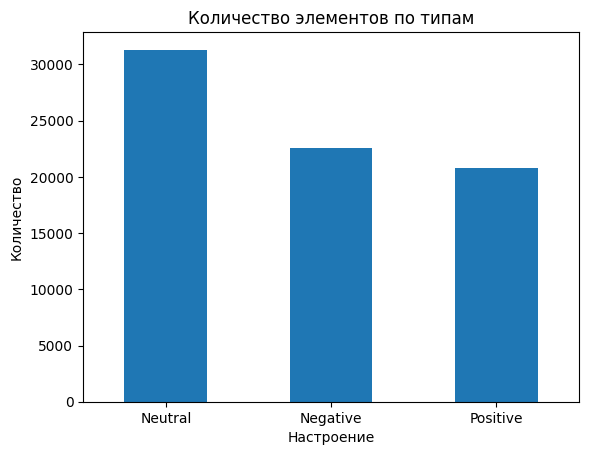

In [ ]:
full_train_df['type'].value_counts().plot(kind='bar', rot=0)
plt.xlabel('Настроение')
plt.ylabel('Количество')
plt.title('Количество элементов по типам')
plt.show()

In [ ]:
full_train_df['information'].value_counts()


,count
information,
Microsoft,2400
MaddenNFL,2400
TomClancysRainbowSix,2400
LeagueOfLegends,2394
CallOfDuty,2394
Verizon,2382
CallOfDutyBlackopsColdWar,2376
ApexLegends,2376
Facebook,2370


In [ ]:
full_train_df.isna().sum()

,0
information,0
type,0
text,686


In [ ]:
full_train_df.loc[(full_train_df['text'].isna()), "type"].unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

In [ ]:
full_train_df.loc[full_train_df.duplicated()].shape

(3707, 3)

# Первоначальная обработка данных

In [ ]:
full_train_df.drop_duplicates(inplace=True)
full_train_df.dropna(inplace=True)

In [ ]:
def prepare_data(df: pd.DataFrame) -> pd.DataFrame:
  prepared_df = df.copy()

  prepared_df['full_text'] = ('Topic: ' + prepared_df['information'].astype(str) +' | Message text: ' + prepared_df['text'].astype(str))

  prepared_df['full_text'] = prepared_df['full_text'].str.replace(r'<[^>]+>', ' ', regex=True)
  prepared_df['full_text'] = prepared_df['full_text'].str.replace(r'\n\n+', '\n', regex=True)
  prepared_df['full_text'] = prepared_df['full_text'].str.replace(r'\t+', ' ', regex=True)
  prepared_df['full_text'] = prepared_df['full_text'].str.replace(r' +', ' ', regex=True)

  return prepared_df

In [ ]:
full_train_df = prepare_data(full_train_df)


In [ ]:
test_df = prepare_data(test_df)


In [ ]:
full_train_df.drop(["information", "text"], axis=1, inplace=True)
test_df.drop(["information", "text"], axis=1, inplace=True)

In [ ]:
train_df, val_df = train_test_split(
    full_train_df,
    test_size=0.1,
    random_state=42
)

In [ ]:
y_train = train_df['type']
y_val = val_df['type']
y_test = val_df['type']

In [ ]:
train_df.to_csv("train_df.csv", index=False)
val_df.to_csv("val_df.csv", index=False)
test_df.to_csv("test_df.csv", index=False)

# Обучение Берта и линейной части

In [ ]:
class BertCls(nn.Module):
    def __init__(self, bert_name: str, num_labels: int = 3, dropout: float = 0.1, class_weights=None):
        super().__init__()
        self.bert = AutoModel.from_pretrained(
            bert_name,
            hidden_dropout_prob=dropout,
            attention_probs_dropout_prob=dropout
        )
        hidden = self.bert.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden, num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)

        cls = outputs.last_hidden_state[:, 0]
        cls = self.dropout(cls)
        logits = self.classifier(cls)

        if labels is not None:
            loss = self.loss_fn(logits, labels)         #
            return {"loss": loss, "logits": logits}
        return {"logits": logits}


In [ ]:
MODEL_NAME = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
tokenizer   = AutoTokenizer.from_pretrained(MODEL_NAME, num_labels=4)

In [ ]:
model = BertCls(MODEL_NAME).to(device)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=160)

In [ ]:
train_bert_df = train_df.copy()
val_bert_df = val_df.copy()

In [ ]:
label_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}

In [ ]:
train_bert_df['type'] = train_bert_df['type'].map(label_map).astype('int64')
val_bert_df['type']   = val_bert_df['type'].map(label_map).astype('int64')

In [ ]:
train_bert_df = train_bert_df[['full_text', 'type']].rename(columns={'full_text': 'text', 'type': 'label'})
val_bert_df = val_bert_df[['full_text', 'type']].rename(columns={'full_text': 'text', 'type': 'label'})

In [ ]:
train_hf_dataset = HFDataset.from_pandas(train_bert_df)
val_hf_dataset = HFDataset.from_pandas(val_bert_df)

In [ ]:
tokenized_train = train_hf_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_val = val_hf_dataset.map(tokenize_function, batched=True, remove_columns=['text'])

Map:   0%|          | 0/63798 [00:00<?, ? examples/s]

Map:   0%|          | 0/7089 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
        output_dir="/content/Model_bert",
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="steps",
        logging_steps=200,
        learning_rate= 3.5e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        save_total_limit=2,
        num_train_epochs=3,
        weight_decay= 0.09,
        warmup_ratio= 0.1,
        lr_scheduler_type="linear",
        bf16=torch.cuda.is_bf16_supported(),
        fp16=not torch.cuda.is_bf16_supported(),
        seed=42,
        report_to="tensorboard",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro",
        greater_is_better=True,
    )

In [ ]:
def compute_f1_score(y_true, y_pred):
    score = f1_score(y_true, y_pred)
    print(f"F1 Score: {score:.6f}")
    return score

In [ ]:
def compute_metrics_for_trainer(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, tuple):
        logits = logits[0]
    preds = np.argmax(logits, axis=1)
    f1_macro = f1_score(labels, preds, average='macro')
    return {"f1_macro": f1_macro}

In [ ]:
trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics_for_trainer,
        processing_class=tokenizer
    )

In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.400600,0.358604,0.865328
2,0.217900,0.257442,0.925438
3,0.099800,0.283910,0.936493


TrainOutput(global_step=11964, training_loss=0.32458967494550095, metrics={'train_runtime': 7203.6378, 'train_samples_per_second': 26.569, 'train_steps_per_second': 1.661, 'total_flos': 0.0, 'train_loss': 0.32458967494550095, 'epoch': 3.0})

# Сохранение модели


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

!cp -r /content/Model_bert /content/drive/MyDrive/nlp_cls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Загрузка готовой модели и eval


In [12]:
class BertCls(nn.Module):
    def __init__(self, bert_name: str, num_labels: int = 3, dropout: float = 0.1, class_weights=None):
        super().__init__()
        self.bert = AutoModel.from_pretrained(
            bert_name,
            hidden_dropout_prob=dropout,
            attention_probs_dropout_prob=dropout
        )
        hidden = self.bert.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden, num_labels)
        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)

        cls = outputs.last_hidden_state[:, 0]
        cls = self.dropout(cls)
        logits = self.classifier(cls)

        if labels is not None:
            loss = self.loss_fn(logits, labels)         #
            return {"loss": loss, "logits": logits}
        return {"logits": logits}


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
from safetensors.torch import load_file

In [6]:
model_dir = "/content/drive/MyDrive/Model_bert/Model_bert/checkpoint-11964"

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_dir)

In [8]:
state_dict = load_file(f"{model_dir}/model.safetensors")


In [11]:
model = BertCls("cardiffnlp/twitter-roberta-base-sentiment-latest")
model.load_state_dict(state_dict)
model.to(device)
model.eval()

BertCls(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm(

In [13]:
train_df = pd.read_csv("train_df.csv")
val_df = pd.read_csv("val_df.csv")
test_df = pd.read_csv("test_df.csv")

In [14]:
texts_to_predict = train_df["full_text"].tolist()

In [20]:
predictions_train = []

In [1]:

for i in range(0, len(texts_to_predict), 32):
  batch_texts = texts_to_predict[i:i + 32]
  inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True,
                           max_length=160)
  inputs = {k: v.to("cuda") for k, v in inputs.items()}
  inputs.pop("token_type_ids", None)
  with torch.no_grad():
    outputs = model(**inputs)
    preds = torch.softmax(outputs["logits"], dim=-1)
    predictions_train.extend(preds.cpu().numpy())

In [24]:
predictions_train = np.array(predictions_train)

In [29]:
print(len(texts_to_predict), predictions_train.shape)

7089 (63798, 3)


In [30]:
texts_to_predict = val_df["full_text"].tolist()

In [2]:
predictions_val = []
for i in range(0, len(texts_to_predict), 32):
  batch_texts = texts_to_predict[i:i + 32]
  inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True,
                           max_length=160)
  inputs = {k: v.to("cuda") for k, v in inputs.items()}
  inputs.pop("token_type_ids", None)
  with torch.no_grad():
    outputs = model(**inputs)
    preds = torch.softmax(outputs["logits"], dim=-1)
    predictions_val.extend(preds.cpu().numpy())

In [33]:
predictions_val = np.array(predictions_val)

In [34]:
print(len(texts_to_predict), predictions_val.shape)

7089 (7089, 3)


In [35]:
texts_to_predict = test_df["full_text"].tolist()

In [3]:
predictions_test = []
for i in range(0, len(texts_to_predict), 32):
  if i % 8_000 == 0:
    print('8_000')
  batch_texts = texts_to_predict[i:i + 32]
  inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True,
                           max_length=160)
  inputs = {k: v.to("cuda") for k, v in inputs.items()}
  inputs.pop("token_type_ids", None)
  with torch.no_grad():
    outputs = model(**inputs)
    preds = torch.softmax(outputs["logits"], dim=-1)
    predictions_test.extend(preds.cpu().numpy())

In [37]:
predictions_test = np.array(predictions_test)

In [38]:
print(len(texts_to_predict), predictions_test.shape)

1000 (1000, 3)


In [43]:
np.array(predictions_train).shape

(63798, 3)

In [39]:
np.save("/content/predictions_train_proba.npy", np.array(predictions_train))


In [40]:
np.save("/content/predictions_val_proba.npy", np.array(predictions_val))


In [41]:
np.save("/content/predictions_test_proba.npy", np.array(predictions_test))
